# Quickstart

### Installation

CredoAI Lens can be installed with pip from PyPI as follows:

`pip install credoai-lens`

Optional dependencies can be installed as follows:

`pip install 'credoai-lens[extras]'`

### Find the code
This notebook can be found on [github](https://github.com/credo-ai/credoai_lens/blob/develop/docs/notebooks/quickstart.ipynb).

## Overview

CredoAI Lens is the assessment framework component of the broader CredoAI suite.
It is usable as a standalone gateway to assessments or in combination
with CredoAI's Governance Platform. 

Understanding how your AI systems are operating is the most important step in intervening upon your system. From the technically complicated questions of improving a system to the business-relevant questions of whether to deploy a system - everything is fundamentally founded upon good observability. Lens strives to make assessment comprehensive, easy, and adaptable.

### Assessments

CredoAI Lens is an entry point to assessments developed by CredoAI, as well as the broader ecosystem of open-source assessments. Custom analytics can also be folded in easily (see the `lens customization` notebook)

AI system assessment starts with verifying standard performance metrics to an evolving set of assessments falling under the banner of *Responsible AI*. A non-exhaustive list includes

* Fairness
* Explainability
* Performance
* Robustness

These different categories of assessment differ substantially based on whether one is 
evaluating datasets or models, what kind of model (e.g., tabular, NLP, computer vision), and the use-case. As the ecosystem develops, Lens will support assessing a broader range of AI systems. Currently, we are focused on Fairness.

### Governance

While Lens is a stand-alone assessment framework, its value is increased when combined with the CredoAI Governance Platform. The platform supports multi-stakeholder `Alignment` on how to assess your AI systems (e.g., what does good look like for this system?). It also supports translating assessment results into a Risk perspective that is scalable across your organization and understandable to diverse stakeholders.



## Lens in 5 minutes

Get your data and models together! Here we have a support vector machine trained on the UCI Credit Card Default Dataset. No train/test split needed for this tutorial!

In [1]:
# imports for example data and model training
from credoai.data import fetch_creditdefault
from sklearn.ensemble import GradientBoostingClassifier

# Base Lens imports
import credoai.lens as cl

In [2]:
data = fetch_creditdefault()
df = data['data']
df['target'] = data['target'].astype(int)

In [20]:
model = GradientBoostingClassifier()
X = df.drop(columns=['SEX', 'target'])
y = df['target']
model.fit(X, y)

## Using Lens

Below is a basic example where our goal is to evaluate the fairness of the above model. We will rely on Lens defaults for this analysis.

### Quick Reference
Below are all the steps needed to assess a model using Lens. We'll break these down [below](#Breaking-Down-The-Steps).

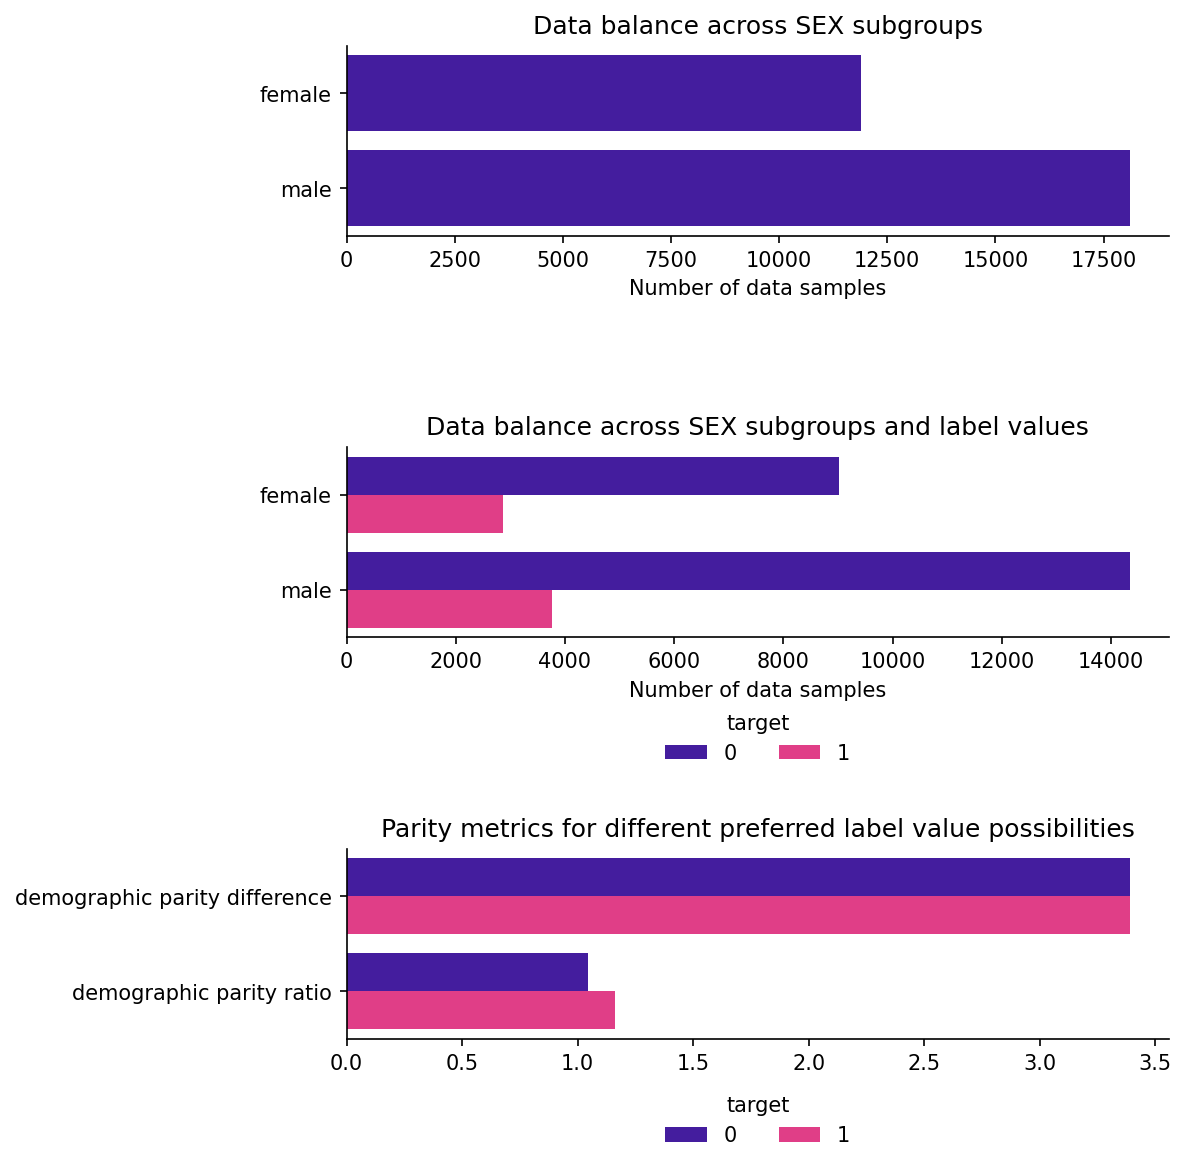

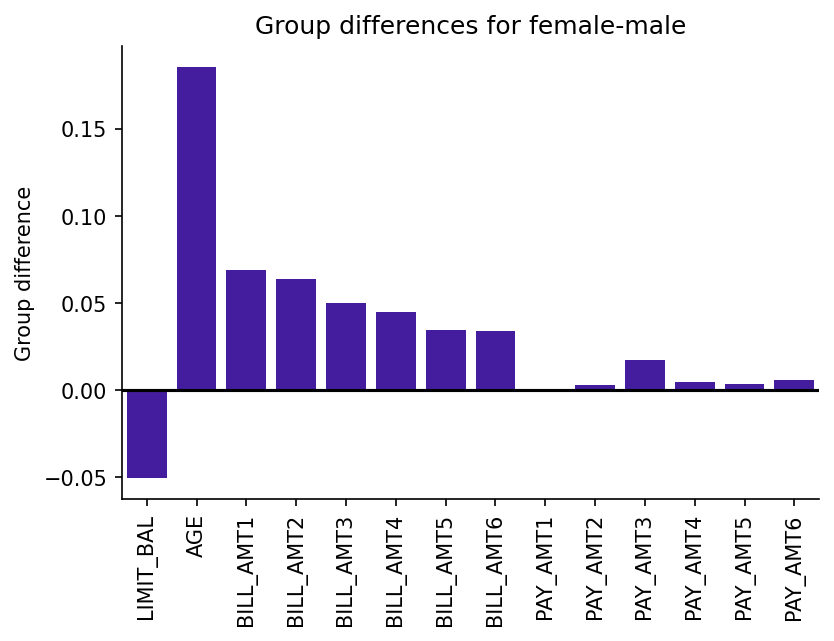

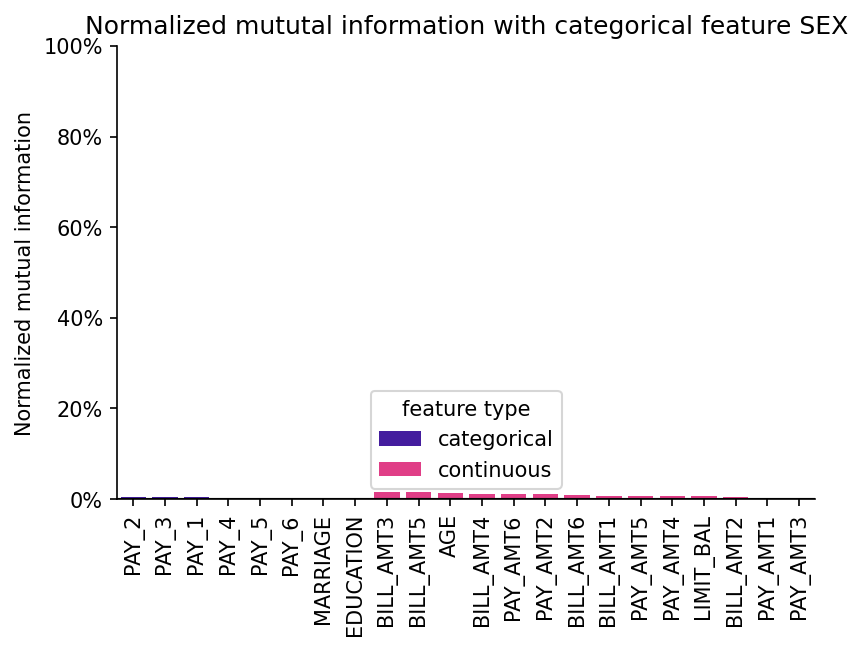

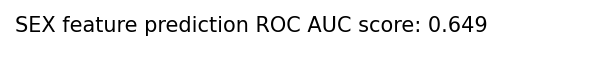

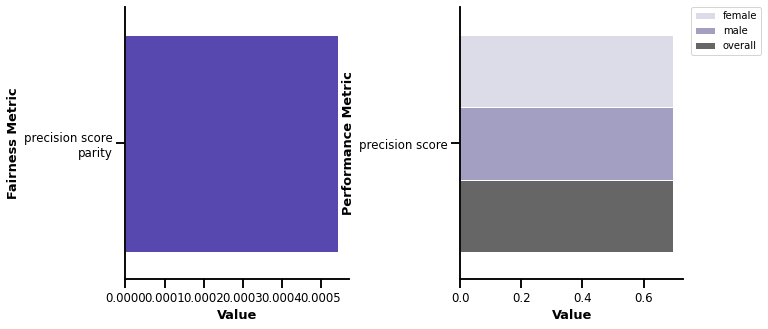

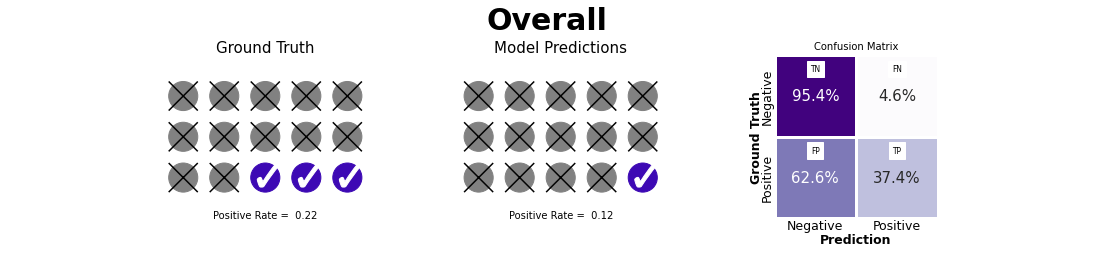

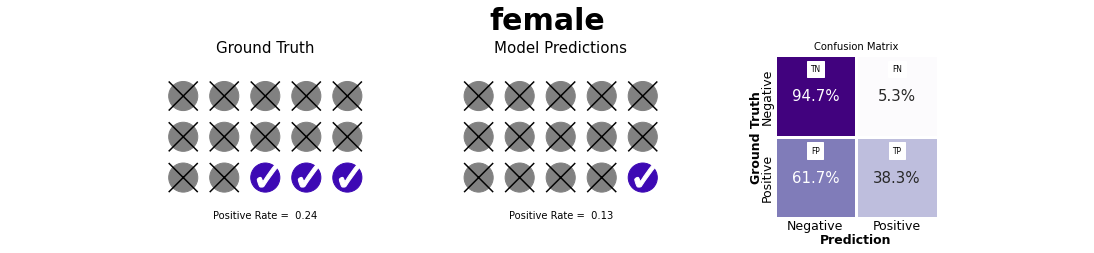

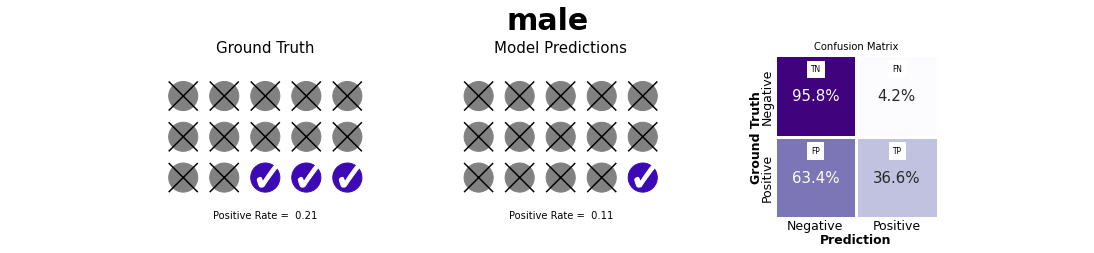

In [4]:
# set up moden and data artifacts
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model=model)

credo_data = cl.CredoData(name='UCI-credit-default',
                          data=df,
                          sensitive_feature_key='SEX',
                          label_key='target'
                          )

# specify the metrics that will be used by the FairnessBase assessment
alignment_spec = {
    'FairnessBase': {'metrics': ['precision_score']}
}

# run lens
lens = cl.Lens(model=credo_model,
               data=credo_data,
               spec=alignment_spec)
results = lens.run_assessments()
reports = lens.create_reports()

In [5]:
lens.get_assessments()

{'Dataset': <credoai.assessment.assessments.DatasetAssessment at 0x7fc401345950>,
 'FairnessBase': <credoai.assessment.assessments.FairnessBaseAssessment at 0x7fc401345890>}

### Breaking Down The Steps

#### Preparing artifacts

Lens interacts with Credo Artifacts which wrap models and datasets and standardizes them for use by different assessments.
Below we create a `CredoModel` object, which automatically infers that the "model" object is from scikit-learn. We also create a `CredoData` object which is store X, y and sensitive features. Both of these objects are customizable. See `lens_customization.ipynb` for more information.

<br>

In [6]:
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model=model)

credo_data = cl.CredoData(name='UCI-credit-default',
                          data=df,
                          sensitive_feature_key='SEX',
                          label_key='target'
                          )

\
\
**Other ways to use CredoModel**

The way a CredoModel works is by defining a "config" dictionary that outlines the models functionality.

Above the CredoModel functionality was inferred from the fact that the model (GraidentBoostingClassifier) is a scikit-learn model. But under the hood all that happens was it defined a `config`.

<br>



In [7]:
# the config was inferred from the model passed to CredoModel
credo_model.config

{'pred_fun': <bound method GradientBoostingClassifier.predict of GradientBoostingClassifier()>,
 'prob_fun': <function credoai.lens.CredoModel._sklearn_style_config.<locals>.prob_fun(X)>}

\
\
*The Config is all that matters* 

Since the `config` is all that matters, CredoModels are just wrappers around functions. They can accomodate any modeling framework, or even completely custom functions

For instance, we could have created the above `credo_model` like so:

In [8]:
config = {'prob_fun': model.predict_proba,
          'pred_fun':  model.predict}
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model_config=config)

<br>

*Using precomputed values*

A common use case you may run into is wanting to assess *pre-computed* predictions. You don't need Lens to perform inference, just use the inferences you've already generated for assessment.

Below is an example of such a case using the same example. Note that the `pred_fun` still needs to take in an `X` variable to maintain the appropriate function signature. In this case, however, X is completely ignored and the predictions are used.

In [9]:
# precomputed predictions
predictions = model.predict(X)
probs = model.predict_proba(X)
# light wrapping
config = {'pred_fun': lambda X: predictions,
          'prob_fun': lambda X: probs}
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model_config=config)

In [10]:
lens = cl.Lens(model=credo_model,
               data=credo_data,
               spec=alignment_spec)
results = lens.run_assessments()

### Assessments 

Lens uses the functionality of the above artifacts to automatically determine which assessments can be run. In this case the Dataset Assessment and FairnessBase Assessment can be run. You can see what assessments are runnable with the following function.

Assessments can be chosen, rather than inferred. See the [customizing lens notebook](https://credoai-lens.readthedocs.io/en/latest/notebooks/lens_customization.html#Selecting-Assessments) for this functionality.

In [11]:
from credoai.assessment import get_usable_assessments
get_usable_assessments(credo_model, credo_data)

{'Dataset': <credoai.assessment.assessments.DatasetAssessment at 0x7fc421097c50>,
 'FairnessBase': <credoai.assessment.assessments.FairnessBaseAssessment at 0x7fc3b0411910>}

You can also list all assesments, along with their names.

In [12]:
from credoai.assessment.utils import get_assessment_names
get_assessment_names()

{'DatasetAssessment': 'Dataset',
 'FairnessBaseAssessment': 'FairnessBase',
 'NLPEmbeddingBiasAssessment': 'NLPEmbeddingBias',
 'NLPGeneratorAssessment': 'NLPGenerator'}

#### Assessment Documentation

Documentation for each assessment is a bit difficult to understand. Assessments wrap modules, which themselves have documentation. Normally, you don't have to worry about the module itself, except if you are creating your own assessments or want to use the modules directly. The main exception here is if you want to parameterize how you run the assessment

For the assessments, you may be interested in what parameters you can pass to their initialization (which is passed using the `spec` parameter when running Lens)

In [13]:
# Different aspects of documentation you may be interested in
from credoai.assessment import FairnessBaseAssessment

# what parameters can be passed to the initialization?
FairnessBaseAssessment.init_module?

# what requirements are needed? 
# (This is normally included in the assessments base documentation)
assessment = FairnessBaseAssessment()
assessment.get_requirements()

# what does the module require? 
# This is often similar to the parameters passed to assessment initialization
assessment.module?

Init signature: assessment.module(metrics, sensitive_features, y_true, y_pred, y_prob=None)
Docstring:     
Fairness module for Credo AI. Handles any metric that can be
calculated on a set of ground truth labels and predictions, 
e.g., binary classification, multiclass classification, regression.

This module takes in a set of metrics  and provides functionality to:
- calculate the metrics
- create disaggregated metrics

Parameters
----------
metrics : List-like
    list of metric names as string or list of FairnessFunctions.
    Metric strings should in list returned by credoai.utils.list_metrics.
    Note for performance parity metrics like 
    "false negative rate parity" just list "false negative rate". Partiy metrics
    are calculated automatically.
sensitive_features :  (List, pandas.Series, numpy.ndarray)
    The sensitive features which should be used to create subgroups.
y_true : (List, pandas.Series, numpy.ndarray)
    The ground-truth labels (for classification) or target 

#### Alignment Spec

The Alignment Spec describes how the assessments should be run. Think about it is as the *parameterization* of the assessments Lens will run.

If you use the Credo AI Governance Platform, the alignment spec is a principle artifact determined during the *Alignment Phase*. It is the output of multi-stakeholder collaboration. Lens will automatically download the Alignment Spec associated with your governance credentials (which uses another artifact: `CredoGovernance`)

The Alignment Spec retrieved from the Governance Platform is a *subset* of all possible parameterizations of the different assessments you can run. Some parameters are too "in the weeds" for multistakeholder collaboration! However, you have full control of the assessments by manually defining the `spec`. Anything defined in the spec parameter will take precedence over the spec retrieved from the Governance Platform.

**Setting up the Spec**

The alignment spec is a set of {assessment_name: parameter} pairs. The assessment name must be the name of one of the assessments, as returned by `get_usable_assessments` (above). In general, the name will be the name of the method without the trailing "assessment". For example, FairnessBaseAssessment -> "FairnessBase". `get_assessment_names` will tell you the names you need.

The spec's parameters are passed to each Assessments `init_module` function.

Not all assessments *require* a spec, though many can be customized. In the case of "FairnessBase" a spec defining a list of metrics **is** required.

In [14]:
# specify the metrics that will be used by the FairnessBase assessment
alignment_spec = {
    'FairnessBase': {'metrics': ['precision_score']}
}

### Run Lens

Once we have the model and data artifacts, as well as the spec, we can run Lens. By default it will automatically infer which assessments to run, just as we manually did above.

In [15]:
lens = cl.Lens(model=credo_model,
               data=credo_data,
               spec=alignment_spec)

**Getting Assessment Results**

Lens has one primary method: `run_assessments`

`run_assessments` outputs the results into a dictionary that can be used for further processing. If the `export` keyword is used, it can also export the data to a json or straight to Credo AI's governance platform (again, if you are using it!)

In [16]:
results = lens.run_assessments()
results.keys()

dict_keys(['Dataset', 'FairnessBase'])

In [17]:
results['FairnessBase']['fairness']

,value,kind
metric_type,,
precision_score,0.000543,parity


**Creating Reports**

Reports can also be easily created. Note - not all assessments support reports! But if a report can be created, it will be with.

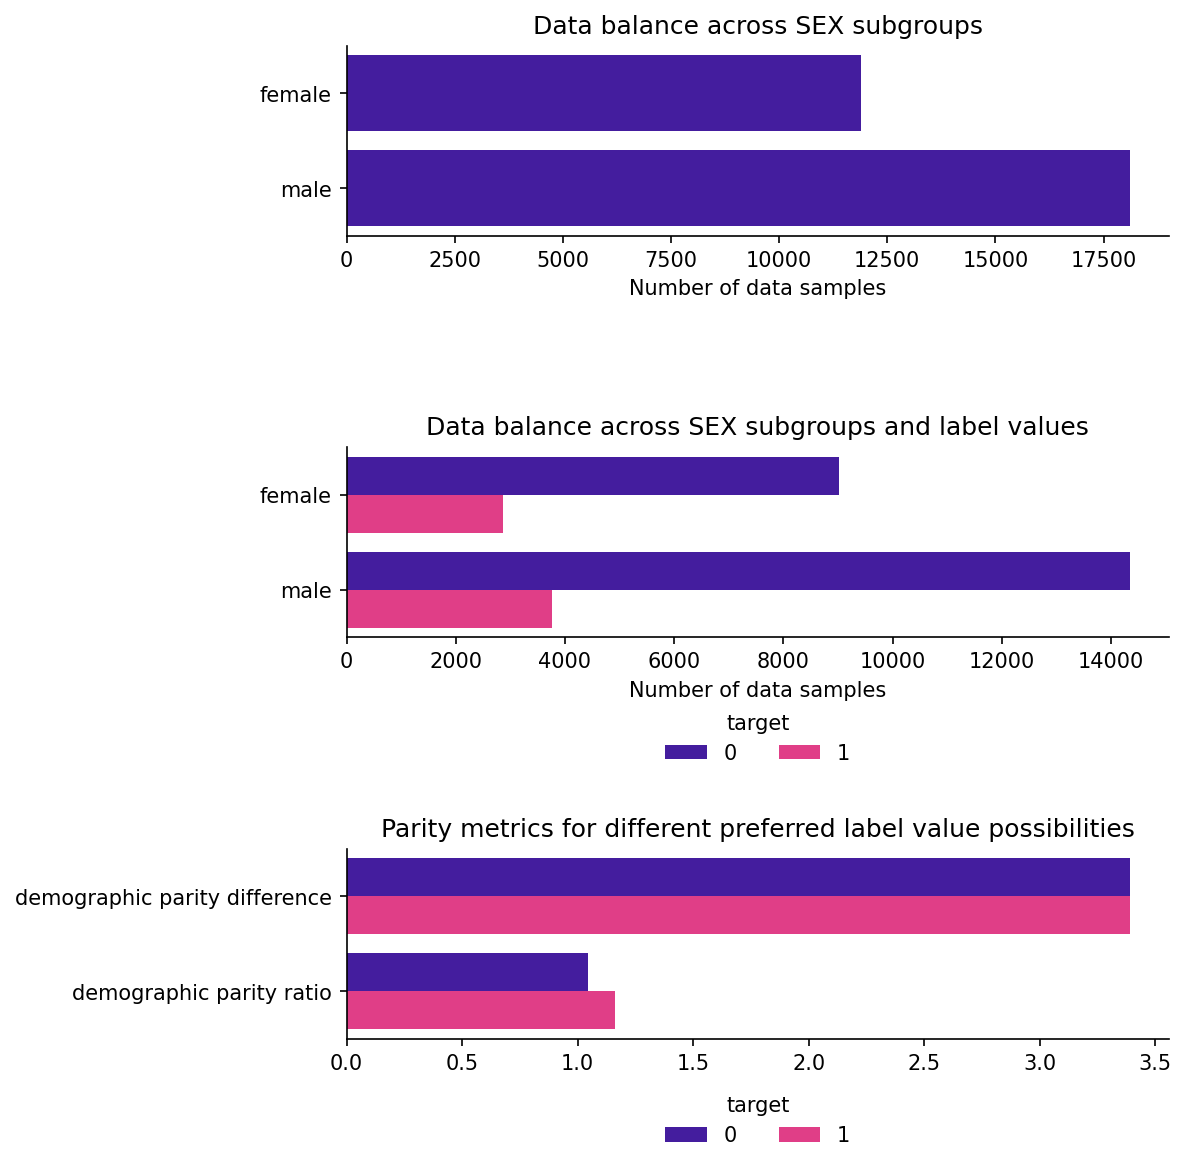

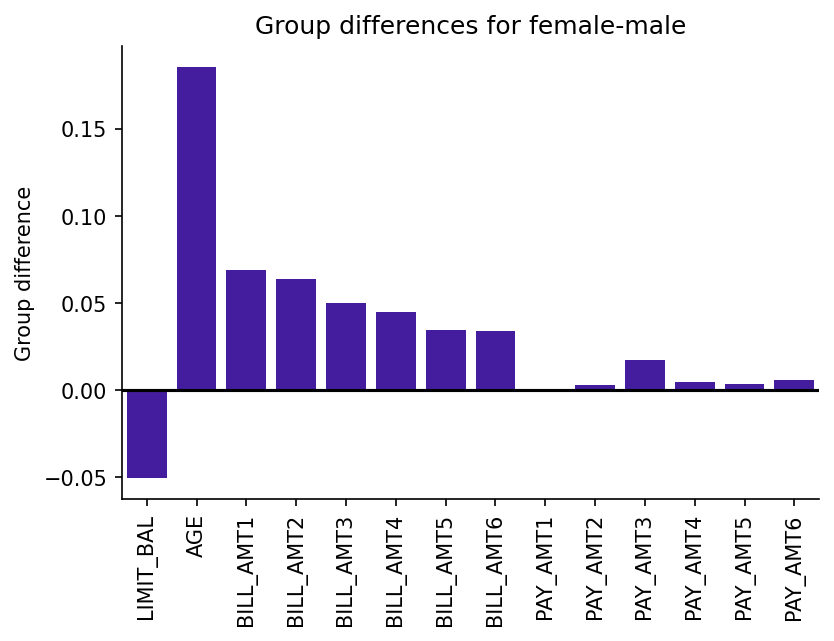

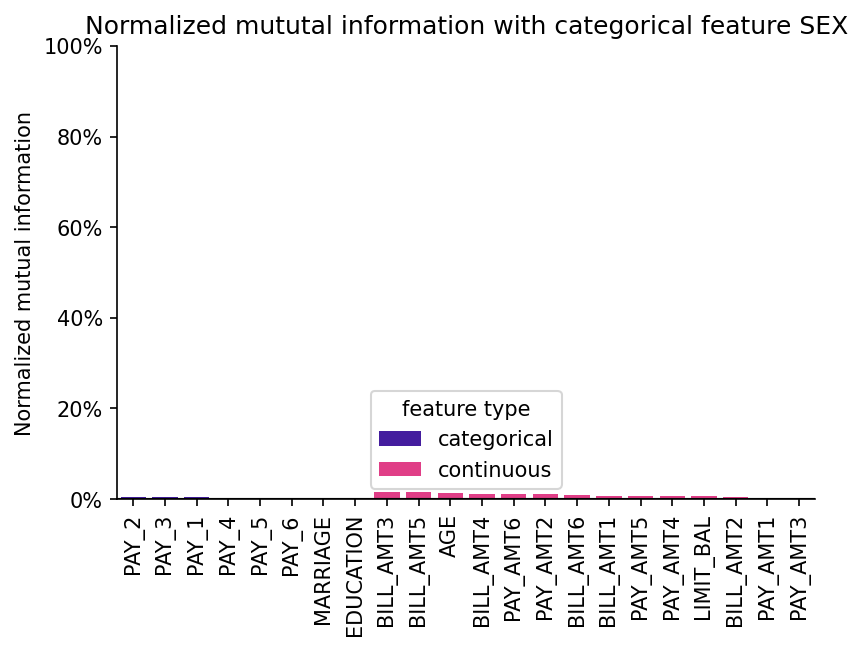

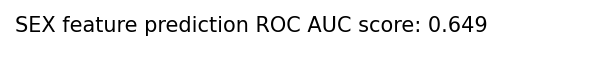

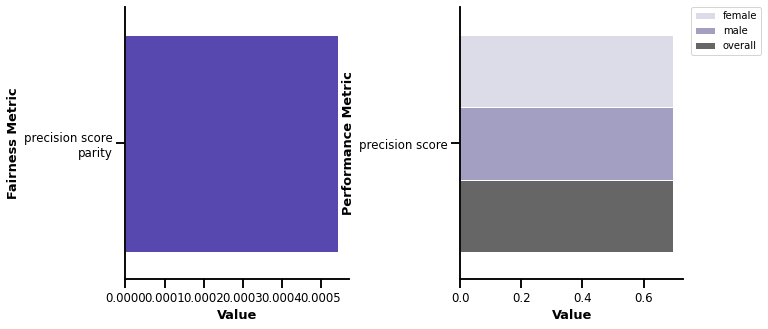

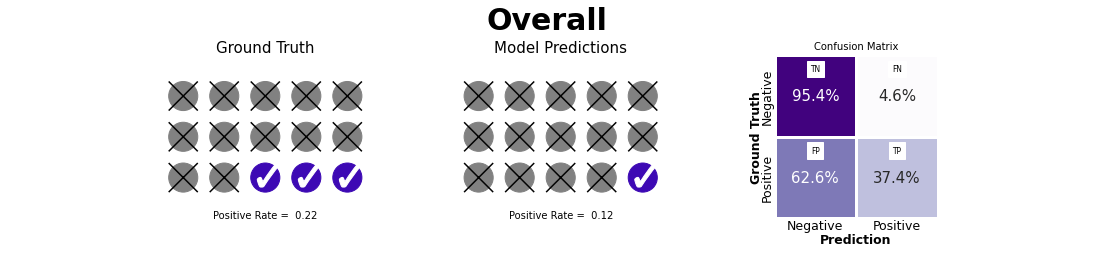

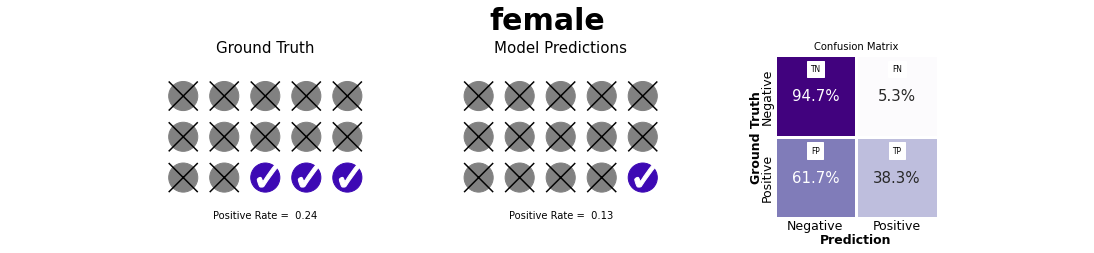

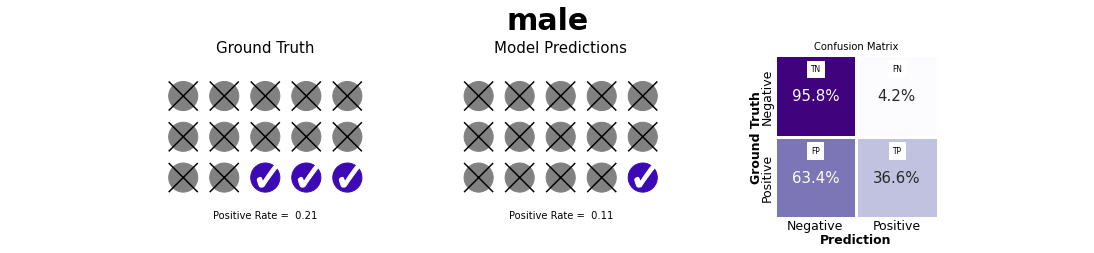

In [18]:
figs = lens.create_reports()

Example export to `~/credoai_test_location`. Uncomment to test.

For export options straight to Credo AI's governance platform, see the Governance Integration notebook.

In [19]:
# # example export
# import os
# output_directory = os.path.join(os.path.expanduser('~'), 'credoai_test_location')
# lens.run_assessments(export=output_directory)